In [1]:
import numpy as np
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import tqdm
import torch.nn.functional as F
import torch.nn as nn
import pickle
import fb_utils as fb

In [9]:
# choose the target filterbank

target = "CQT"
#target = "MEL"
#target = "VQT"

In [10]:
# load hyperparameters

spec = fb.HYPERPARAMS[target]

In [11]:
# load the info about the target fb as dictionaries, containing:
#   "freqz" frequency responses as 2D array (time,channels)
#   "centerfreq" 
#   "bandwidths"
#   "framebounds" computed without subsampling

with open('targets/'+target+'.pkl', 'rb') as fp:
    FB = pickle.load(fp)

FB_freq = FB["freqz"]
FB_torch = torch.from_numpy(FB_freq.T)
FB_torch.shape

torch.Size([42, 4095])

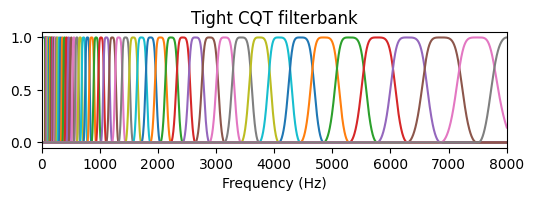

In [13]:
# plot the frequency responses of the target fb

fig = plt.figure(figsize=(6, 1.5))

omega = np.linspace(0, spec["sr"], FB_freq.shape[0])
plt.plot(omega, FB_freq/ np.max(FB_freq, axis=0));
plt.title("Frequency responses")
plt.xlim(0, spec["sr"]//2+1)
plt.xlabel("Frequency (Hz)");

In [4]:
# initialize filters

w_init = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=False, to_torch=True, support_only=True)
np.save('values/'+target+'_w_init.npy', w_init)

In [5]:
# initialize data generator

synth = fb.generate_random_sine(
    spec["sr"],
    spec["fmin"],
    spec["fmax"],
    spec["N"],
    spec["batch_size"])

In [14]:
# conv1D layer with circulant boundary conditions and pooling

class TDFilterbank(torch.nn.Module):
    def __init__(self, spec, w):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=spec["stride"],
            padding=0,
            bias=False)

        self.psi.weight.data = w[:, :spec["T"]].unsqueeze(1).float()        
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = torch.abs(self.psi(x))
        hann = torch.hann_window(spec["N"]//spec["stride"]).unsqueeze(0).unsqueeze(0)
        phi = torch.ones(spec["J"], spec["J"], spec["N"]//spec["stride"])*hann
        Ux = F.conv1d(Wx, phi, bias=None, stride=1, padding=0)
        return Ux
    
baseline = TDFilterbank(spec, w_init)
print(baseline)

TDFilterbank(
  (psi): Conv1d(1, 58, kernel_size=(1024,), stride=(341,), bias=False)
)


In [15]:
# check output sizes

print('filterbank:', fb.filterbank_response_fft(next(synth), FB_torch, spec).shape)
print('convnet:', baseline(next(synth)).shape)

filterbank: torch.Size([64, 58, 1])
convnet: torch.Size([64, 58, 1])


In [16]:
# loss function penalizing cosine similarity and kappa

class KappaLoss(nn.Module):
    def __init__(self):
        super(KappaLoss, self).__init__()
        self.loss = nn.CosineSimilarity(dim=0)

    def forward(self, inputs, targets, w, beta):
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        B = torch.max(w_hat,dim=0).values
        A = torch.min(w_hat,dim=0).values
        loss = 0.5*torch.mean(1-self.loss(inputs, targets)) + beta*B/A
        return loss

In [17]:
# training function

def train(baseline, penalization, lr, beta, n_epochs, epoch_size):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    cos = torch.nn.CosineSimilarity(dim=0)
    criterion = KappaLoss()
    if penalization == 'cos':
        beta=0
    if penalization == 'kappa':
        beta=beta
    losses = []
    conditions = []

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(synth)
        outputs = baseline(inputs)
        targets = fb.filterbank_response_fft(inputs, FB_torch, spec)
        loss = 0.5*torch.mean(1-cos(outputs, targets))
        running_loss += loss.item()
    print(1000 * running_loss)

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, spec["N"]-spec["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)
    
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(synth)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = fb.filterbank_response_fft(inputs, FB_torch, spec)

            w = baseline.psi.weight[:,0,:]
            w = F.pad(w,(0,spec["N"]-spec["T"]), value=0)
            loss = criterion(outputs, targets, w, beta)

            loss.backward()
            optimizer.step()

            loss2 = 0.5*torch.mean(1-cos(outputs, targets))
            running_loss += loss2.item()
        losses.append(running_loss)

        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.pad(w, ((0,0),(0, spec["N"]-spec["T"])), constant_values=0)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)

        print(1000 * running_loss)

    return losses, conditions

In [18]:
# training hyperparameters

n_epochs = 50
epoch_size = 100
lr = 1e-6
if target == 'CQT':
    beta = 0.00001
if target == 'MEL':
    beta = 0.0001
if target == 'VQT':
    beta = 0.0005

In [19]:
# train: no penalization

baseline_no = TDFilterbank(spec, w_init)
losses_no, conditions_no = train(
    baseline=baseline_no,
    penalization='cos',
    lr=lr,
    beta=beta,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_no = baseline_no.psi.weight.detach().numpy()[:,0,:]
np.save('values/'+target+'_losses_no.npy', losses_no)
np.save('values/'+target+'_conditions_no.npy', conditions_no)
np.save('values/'+target+'_w_no.npy', w_no)

576.957035344094


  3%|▎         | 3/100 [00:02<01:25,  1.13it/s]


KeyboardInterrupt: 

In [48]:
# train: kappa penalization

baseline_kappa = TDFilterbank(spec, w_init)
losses_kappa, conditions_kappa = train(
    baseline=baseline_kappa,
    penalization='kappa',
    lr=lr,
    beta=beta,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_kappa = baseline_kappa.psi.weight.detach().numpy()[:,0,:]
np.save('values/'+target+'_losses_kappa.npy', losses_kappa)
np.save('values/'+target+'_conditions_kappa.npy', conditions_kappa)
np.save('values/'+target+'_w_kappa.npy', w_kappa)

550.4776660818607


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


312.3608431778848


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


162.45386010268703


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


119.87932090414688


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


87.65263290842995


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


77.71057719946839


100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


63.63375412183814


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


56.68680736562237


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


54.087768541648984


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


51.491435209754854


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


53.309099428588524


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


46.74038611119613


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


45.77466132468544


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


44.997008837526664


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


45.43014129740186


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


40.74498396948911


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


43.38257166091353


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


42.42798575432971


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


36.89302763086744


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


40.07099219597876


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


38.0215882032644


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


39.10004690987989


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


35.97106185043231


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


36.88128854264505


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


38.406473788199946


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


34.467443416360766


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


35.52585525903851


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


34.01788556948304


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


32.34274426358752


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


30.95558998757042


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


33.312803658191115


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


33.19392632693052


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


31.09068505000323


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


36.24512723763473


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


28.879247951408615


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


28.688459569821134


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


31.491265195654705


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


29.721933242399246


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


32.15455493773334


100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


28.398759342962876


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


28.18813710473478


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


26.123130141058937


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


26.824665430467576


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


29.39243463333696


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


28.700565482722595


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


26.498539664316922


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


25.689353176858276


100%|██████████| 100/100 [03:28<00:00,  2.08s/it]


26.868995919357985


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


26.640451222192496


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


28.73655635630712


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]

25.183039491821546


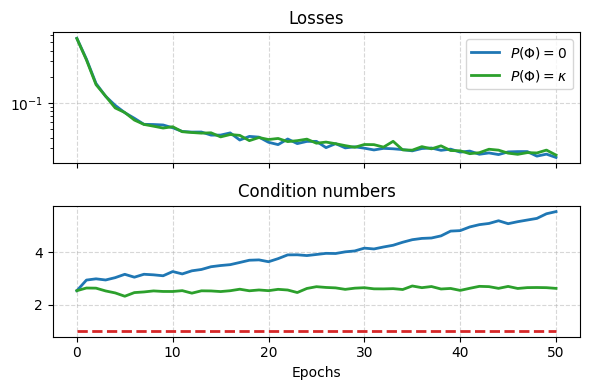

In [53]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses_no, 'tab:blue', linewidth=2, label='$P(\Phi)=0$')
ax.plot(Ts, losses_kappa, 'tab:green', linewidth=2, label='$P(\Phi)=\kappa$')

ax.set_yscale('log')
ax.set_title(target+' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions_no, 'tab:blue', linewidth=2)
ax.plot(Ts, conditions_kappa, 'tab:green', linewidth=2)
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, label='Tightened', linestyle='--')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='upper right')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fitting_'+target+'.pdf', bbox_inches='tight')